# Titrating variables in large switching RNN

In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
from numpy import linalg as LA


import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_models import TwoHemiRNNTanh_asymmetric_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


## % neurons perturbed vs the dip (measure of modularity)

Dip measurement:

In [3]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_fixed_input_cross_hemi_switch"
exp.configs['init_cross_hemi_rel_factor'] = 0.5
exp.configs['random_seed'] = 0
exp.configs['switch_epoch_n'] = 0
exp.configs['switch_ps'] = [0.89, 0.05, 0.05, 0.01]
exp.configs['n_epochs'] = 45

model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_18.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()

model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi_switch/n_neurons_256_random_seed_0/switch_epoch_n_0_ps_0.89/n_epochs_45_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.50/last_model.pth


array([[ 0.01443497, -0.01591364,  0.02709272, ..., -0.05507335,
        -0.00629457, -0.05928842],
       [ 0.02876332,  0.00998897, -0.02299002, ...,  0.05478624,
        -0.02791953, -0.03543988],
       [ 0.02923037,  0.04954519,  0.05265322, ..., -0.00724704,
         0.02049702,  0.04911873],
       ...,
       [ 0.01233128, -0.02776525,  0.00114518, ..., -0.05443844,
         0.03356605, -0.02561431],
       [ 0.05024819,  0.09657265,  0.05144915, ...,  0.03934854,
        -0.00092049,  0.00160439],
       [-0.03547834,  0.01891172,  0.02127733, ..., -0.00223018,
        -0.00124398, -0.00297411]], dtype=float32)

In [4]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_same_noise.npy' ))
train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


In [ ]:


### After data loading, run model # with no noise:
model.train_type = "train_type_modular_fixed_input_cross_hemi"
model.return_input = True


# Pass input into model
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)  # 3 conditions, 2 hemispheres

# Define condition names for labeling
condition_names = [
    "Control (no perturb)", 
    "Left ALM perturbed", 
    "Right ALM perturbed"
]
# For legend management
line_objs = [[None, None] for _ in range(3)]

# For each of the three conditions: control, left alm pert, right alm pert
for rowidx, (uni_pert, left_pert) in enumerate([
        (0.0, 0.5),   # Control: no perturb
        (1.0, 1.0),   # Left ALM perturbed
        (1.0, 0.0)    # Right ALM perturbed
    ]):

    # Set model perturbation parameters for condition
    model.uni_pert_trials_prob = uni_pert
    model.left_alm_pert_prob = left_pert
    _, hs_l, zs_l = model(l_trial_input_all)    # left trial
    _, hs_r, zs_r = model(r_trial_input_all)    # right trial

    for i in range(20):
        # l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
        # r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # Left hemisphere readout subplot (col 0)
        l_line = axs[rowidx,0].plot(left_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line = axs[rowidx,0].plot(left_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][0] = (l_line[0], r_line[0])

        # Right hemisphere readout subplot (col 1)
        l_line2 = axs[rowidx,1].plot(right_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line2 = axs[rowidx,1].plot(right_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][1] = (l_line2[0], r_line2[0])

    # Add light blue bar (span) for perturbation period on perturbation subplots
    # Only add for perturbed conditions (rowidx 1 and 2)
    if rowidx in [1, 2]:
        # perturbation likely in delay epoch; use exp.delay_begin, exp.T for x-range
        axs[rowidx,0].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)
        axs[rowidx,1].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)

    # Titles, labels for each row
    axs[rowidx,0].set_title(f"Left Hemisphere Readout\n({condition_names[rowidx]})" )
    axs[rowidx,1].set_title(f"Right Hemisphere Readout\n({condition_names[rowidx]})")
    axs[rowidx,0].set_ylabel("Readout")
    axs[rowidx,0].set_xlabel("Time")
    axs[rowidx,1].set_xlabel("Time")
    axs[rowidx,0].grid()
    axs[rowidx,1].grid()

# Only show legend in the bottom row for both hemispheres (col 0/col 1)
for col in range(2):
    axs[-1,col].legend()

plt.suptitle(f'Readout Trajectories (switch epoch = {exp.configs["switch_epoch_n"]}, cross weights = {exp.configs["init_cross_hemi_rel_factor"]})')
plt.tight_layout()
plt.show()




In [4]:
exp.pert_begin, exp.pert_end

(56, 88)

In [5]:
# Get quantitative measure of the dip


sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model # with no noise:
model.train_type = "train_type_modular_fixed_input_cross_hemi"
model.return_input = True

pert_begin, pert_end = exp.pert_begin, exp.pert_end
pert_end = pert_begin + 10

model.uni_pert_trials_prob = 0.0
model.left_alm_pert_prob = 0.5
_, hs_l, zs_l = model(l_trial_input_all)    # left trial
_, hs_r, zs_r = model(r_trial_input_all)    # right trial

left_readout_l_ctl = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_l_ctl = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

left_readout_r_ctl = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_r_ctl = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

all_probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

all_dip_diff, all_dip_sem = [],[]

for prob in all_probs:
    dip_diff, dip_sem = [],[]

    # For each of the two conditions: left alm pert, right alm pert
    for rowidx, (uni_pert, left_pert) in enumerate([
            (1.0, 1.0),   # Left ALM perturbed
            (1.0, 0.0)    # Right ALM perturbed
        ]):

        diff, sem = 0,0
        # Set model perturbation parameters for condition
        model.uni_pert_trials_prob = uni_pert
        model.left_alm_pert_prob = left_pert
        model.drop_p_min = prob
        model.drop_p_max = prob

        _, hs_l, zs_l = model(l_trial_input_all)    # left trial
        _, hs_r, zs_r = model(r_trial_input_all)    # right trial

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # only want contra differences 

        if rowidx == 0:

            # diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            # sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
        
        elif rowidx == 1:

            diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))

        dip_diff.append(diff)
        dip_sem.append(sem)

    all_dip_diff.append(dip_diff)
    all_dip_sem.append(dip_sem)







Text(0, 0.5, 'Modularity')

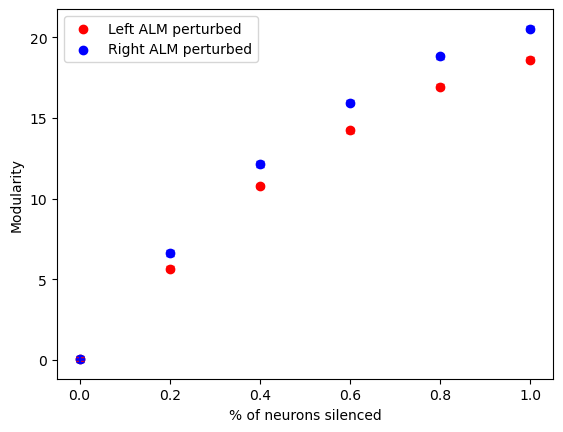

In [6]:
plt.scatter(all_probs, np.array(all_dip_diff)[:,0], c='red', label='Left ALM perturbed')
plt.scatter(all_probs, np.array(all_dip_diff)[:,1], c='blue', label='Right ALM perturbed')
plt.errorbar(all_probs, np.array(all_dip_diff)[:,0], yerr=np.array(all_dip_sem)[:,0], fmt='none', ecolor='red', capsize=3)
plt.errorbar(all_probs, np.array(all_dip_diff)[:,1], yerr=np.array(all_dip_sem)[:,1], fmt='none', ecolor='blue', capsize=3)

plt.legend()
plt.xlabel('% of neurons silenced')
plt.ylabel('Modularity')

Compare this to a vanilla RNN

In [5]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_fixed_input_cross_hemi"
exp.configs['init_cross_hemi_rel_factor'] = 0.2
exp.configs['random_seed'] = 1
exp.configs['switch_epoch_n'] = 0
exp.configs['one_hot'] = 1
exp.configs['n_epochs'] = 40

model = getattr(sys.modules[__name__], exp.configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_15.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()

print(np.sum(np.abs(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())), np.sum(np.abs(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())))
model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_1/unfix_epoch_0/n_epochs_40_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/last_model.pth
822.2494 819.23645


array([[-1.3835171e-02, -8.8256486e-03,  3.3573455e-03, ...,
         7.9787811e-03,  5.3229965e-03,  9.1161318e-03],
       [ 6.2373718e-03, -7.6643773e-05,  1.5343544e-02, ...,
         2.8832445e-03,  9.6692834e-03,  4.5821900e-03],
       [ 1.8272260e-02,  1.2273358e-02,  6.3055558e-03, ...,
         1.3554470e-02,  1.4207014e-02,  3.1298879e-03],
       ...,
       [ 6.8035540e-03, -1.6683389e-02, -1.8078694e-02, ...,
        -1.9806746e-02,  3.3481490e-05,  9.5411129e-03],
       [-1.5494874e-02,  1.0952087e-03, -2.6705205e-02, ...,
        -2.0213794e-02,  1.6328960e-03,  1.4573139e-02],
       [-1.1155932e-02,  1.7323388e-02, -1.1945099e-03, ...,
         1.6413861e-03, -1.3554386e-02, -1.9357834e-02]], dtype=float32)

In [6]:
# Get quantitative measure of the dip


sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model # with no noise:
model.return_input = True

pert_begin, pert_end = exp.pert_begin, exp.pert_end
pert_end = pert_begin + 10

model.uni_pert_trials_prob = 0.0
model.left_alm_pert_prob = 0.5
_, hs_l, zs_l = model(l_trial_input_all)    # left trial
_, hs_r, zs_r = model(r_trial_input_all)    # right trial

left_readout_l_ctl = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_l_ctl = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

left_readout_r_ctl = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_r_ctl = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

all_probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

all_dip_diff_vanilla, all_dip_sem_vanilla = [],[]

for prob in all_probs:
    dip_diff, dip_sem = [],[]

    # For each of the two conditions: left alm pert, right alm pert
    for rowidx, (uni_pert, left_pert) in enumerate([
            (1.0, 1.0),   # Left ALM perturbed
            (1.0, 0.0)    # Right ALM perturbed
        ]):

        diff, sem = 0,0
        # Set model perturbation parameters for condition
        model.uni_pert_trials_prob = uni_pert
        model.left_alm_pert_prob = left_pert
        model.drop_p_min = prob
        model.drop_p_max = prob

        _, hs_l, zs_l = model(l_trial_input_all)    # left trial
        _, hs_r, zs_r = model(r_trial_input_all)    # right trial

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # only want contra differences 

        if rowidx == 0:

            # diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            # sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
        
        elif rowidx == 1:

            diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))

        dip_diff.append(diff)
        dip_sem.append(sem)

    all_dip_diff_vanilla.append(dip_diff)
    all_dip_sem_vanilla.append(dip_sem)







Text(0, 0.5, 'Modularity')

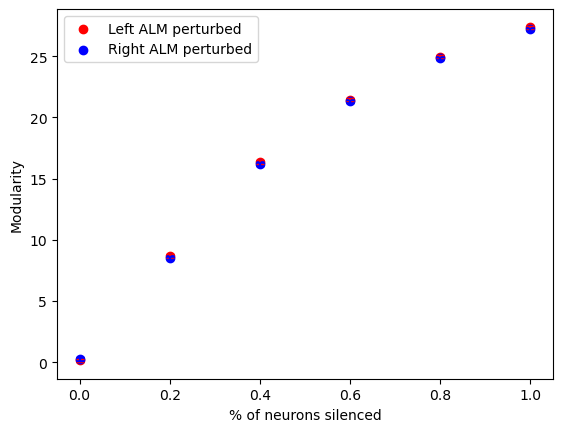

In [48]:
plt.scatter(all_probs, np.array(all_dip_diff_vanilla)[:,0], c='red', label='Left ALM perturbed')
plt.scatter(all_probs, np.array(all_dip_diff_vanilla)[:,1], c='blue', label='Right ALM perturbed')
plt.errorbar(all_probs, np.array(all_dip_diff_vanilla)[:,0], yerr=np.array(all_dip_sem_vanilla)[:,0], fmt='none', ecolor='red', capsize=3)
plt.errorbar(all_probs, np.array(all_dip_diff_vanilla)[:,1], yerr=np.array(all_dip_sem_vanilla)[:,1], fmt='none', ecolor='blue', capsize=3)

plt.legend()
plt.xlabel('% of neurons silenced')
plt.ylabel('Modularity')

### Load alternative RNN

Graded; 0.2

In [7]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_fixed_input_cross_hemi_switch_graded"
exp.configs['init_cross_hemi_rel_factor'] = 0.2
exp.configs['random_seed'] = 4
exp.configs['switch_epoch_n'] = 0
exp.configs['n_epochs'] = 45
exp.configs['switch_ps'] = [0.25, 0.25, 0.25, 0.25]

model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_18.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()

model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi_switch_graded/n_neurons_256_random_seed_4/switch_epoch_graded_0p2/n_epochs_45_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/last_model.pth


array([[ 0.0055455 , -0.00418326, -0.00074166, ...,  0.01392704,
        -0.01908744,  0.00675259],
       [-0.00683886,  0.00824553,  0.01361837, ...,  0.0053261 ,
         0.00716877,  0.00274906],
       [-0.00417053,  0.00644235, -0.00053399, ..., -0.02413989,
         0.00187102,  0.01645404],
       ...,
       [ 0.00585866,  0.01337782,  0.00572499, ..., -0.00155364,
        -0.01414411,  0.00795544],
       [-0.00661585,  0.00662884, -0.00268099, ...,  0.00606698,
        -0.01942925, -0.01143437],
       [-0.01334648,  0.00907338,  0.00803629, ..., -0.00384601,
        -0.00712507,  0.0094222 ]], dtype=float32)

In [8]:
# Get quantitative measure of the dip


sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model # with no noise:
model.train_type = "train_type_modular_fixed_input_cross_hemi"
model.return_input = True

pert_begin, pert_end = exp.pert_begin, exp.pert_end
pert_end = pert_begin + 10

model.uni_pert_trials_prob = 0.0
model.left_alm_pert_prob = 0.5
_, hs_l, zs_l = model(l_trial_input_all)    # left trial
_, hs_r, zs_r = model(r_trial_input_all)    # right trial

left_readout_l_ctl = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_l_ctl = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

left_readout_r_ctl = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
)
right_readout_r_ctl = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
    model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
)

all_probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

all_dip_diff, all_dip_sem = [],[]

for prob in all_probs:
    dip_diff, dip_sem = [],[]

    # For each of the two conditions: left alm pert, right alm pert
    for rowidx, (uni_pert, left_pert) in enumerate([
            (1.0, 1.0),   # Left ALM perturbed
            (1.0, 0.0)    # Right ALM perturbed
        ]):

        diff, sem = 0,0
        # Set model perturbation parameters for condition
        model.uni_pert_trials_prob = uni_pert
        model.left_alm_pert_prob = left_pert
        model.drop_p_min = prob
        model.drop_p_max = prob

        _, hs_l, zs_l = model(l_trial_input_all)    # left trial
        _, hs_r, zs_r = model(r_trial_input_all)    # right trial

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[:, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[:, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # only want contra differences 

        if rowidx == 0:

            # diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            # sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
        
        elif rowidx == 1:

            diff = np.sum(np.abs(np.mean(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            diff += np.sum(np.abs(np.mean(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0)))
            # diff += np.sum(np.abs(np.mean(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0)))

            sem = np.sum(np.std(left_readout_l[:, pert_begin:pert_end] - left_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            sem += np.sum(np.std(left_readout_r[:, pert_begin:pert_end] - left_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_l[:, pert_begin:pert_end] - right_readout_l_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))
            # sem += np.sum(np.std(right_readout_r[:, pert_begin:pert_end] - right_readout_r_ctl[:, pert_begin:pert_end], axis=0) / np.sqrt(left_readout_l.shape[0]))

        dip_diff.append(diff)
        dip_sem.append(sem)

    all_dip_diff.append(dip_diff)
    all_dip_sem.append(dip_sem)







### overlay both plots to compare vanilla vs switching rnn


Text(0, 0.5, 'Effect of contra perturbation')

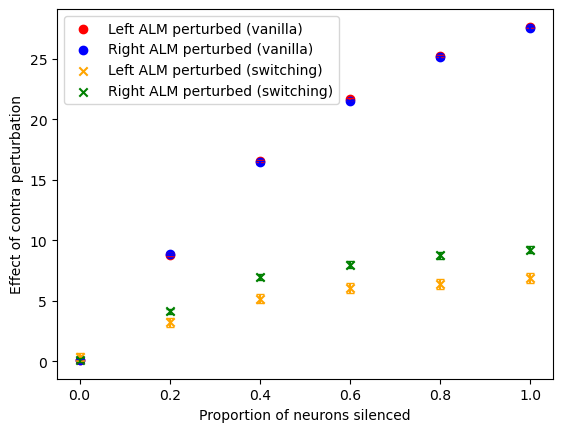

In [9]:
# Overlay both vanilla and switching dip differences and sems with appropriate scatter and error bars

plt.scatter(all_probs, np.array(all_dip_diff_vanilla)[:,0], c='red', label='Left ALM perturbed (vanilla)', marker='o')
plt.scatter(all_probs, np.array(all_dip_diff_vanilla)[:,1], c='blue', label='Right ALM perturbed (vanilla)', marker='o')
plt.errorbar(all_probs, np.array(all_dip_diff_vanilla)[:,0], yerr=np.array(all_dip_sem_vanilla)[:,0],
             fmt='none', ecolor='red', capsize=3)
plt.errorbar(all_probs, np.array(all_dip_diff_vanilla)[:,1], yerr=np.array(all_dip_sem_vanilla)[:,1],
             fmt='none', ecolor='blue', capsize=3)

plt.scatter(all_probs, np.array(all_dip_diff)[:,0], c='orange', label='Left ALM perturbed (switching)', marker='x')
plt.scatter(all_probs, np.array(all_dip_diff)[:,1], c='green', label='Right ALM perturbed (switching)', marker='x')
plt.errorbar(all_probs, np.array(all_dip_diff)[:,0], yerr=np.array(all_dip_sem)[:,0],
             fmt='none', ecolor='orange', capsize=3)
plt.errorbar(all_probs, np.array(all_dip_diff)[:,1], yerr=np.array(all_dip_sem)[:,1],
             fmt='none', ecolor='green', capsize=3)

plt.legend()
plt.xlabel('Proportion of neurons silenced')
plt.ylabel('Effect of contra perturbation')

## Replicate this trend across many seeds

In [14]:
all_sherlock_runs = np.load('figs/sherlock_modularity_analysis.npy', allow_pickle=True).item()
all_sherlock_vanilla_runs = np.load('figs/sherlock_modularity_vanilla_analysis.npy', allow_pickle=True).item()

all_probs = [0,0.2,0.4,0.6,0.8,1.0]

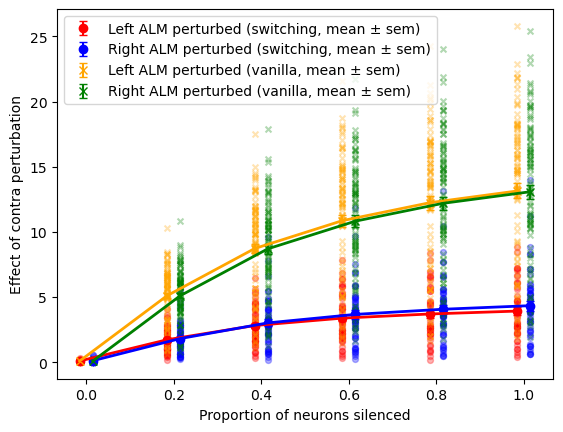

In [38]:
# Collect dip differences across seeds for given probability (0.2)
dip_diffs_left = []
dip_diffs_right = []

dip_diffs_left_vanilla = []
dip_diffs_right_vanilla = []

# Small horizontal offset for better visualization
offset = 0.015

all_probs = np.array(all_probs)  # ensure numpy array for vectorization

# Sherlock switching (51 seeds)
for seed in range(51):
    arr = np.array(all_sherlock_runs[seed][0.2]['all_dip_diff'])
    dip_diffs_left.append(arr[:,0])
    dip_diffs_right.append(arr[:,1])

dip_diffs_left = np.array(dip_diffs_left)      # (51, len(all_probs))
dip_diffs_right = np.array(dip_diffs_right)    # (51, len(all_probs))

mean_left = dip_diffs_left.mean(axis=0)
sem_left = dip_diffs_left.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left.shape[0])
mean_right = dip_diffs_right.mean(axis=0)
sem_right = dip_diffs_right.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right.shape[0])

# Sherlock vanilla (100 seeds)
for seed in range(100):
    arr_vanilla = np.array(all_sherlock_vanilla_runs[seed][0.1]['all_dip_diff'])
    dip_diffs_left_vanilla.append(arr_vanilla[:,0])
    dip_diffs_right_vanilla.append(arr_vanilla[:,1])

dip_diffs_left_vanilla = np.array(dip_diffs_left_vanilla)      # (100, len(all_probs))
dip_diffs_right_vanilla = np.array(dip_diffs_right_vanilla)    # (100, len(all_probs))

mean_left_vanilla = dip_diffs_left_vanilla.mean(axis=0)
sem_left_vanilla = dip_diffs_left_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left_vanilla.shape[0])
mean_right_vanilla = dip_diffs_right_vanilla.mean(axis=0)
sem_right_vanilla = dip_diffs_right_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right_vanilla.shape[0])

# Scatter individual seeds with slight x-offset for left/right - switching (red/blue, 'o')
for seed in range(51):
    plt.scatter(all_probs - offset, dip_diffs_left[seed], color='red', alpha=0.3, s=18)
    plt.scatter(all_probs + offset, dip_diffs_right[seed], color='blue', alpha=0.3, s=18)
# Scatter individual seeds for vanilla (orange/green, 'x')
for seed in range(100):
    plt.scatter(all_probs - offset, dip_diffs_left_vanilla[seed], color='orange', alpha=0.3, s=18, marker='x')
    plt.scatter(all_probs + offset, dip_diffs_right_vanilla[seed], color='green', alpha=0.3, s=18, marker='x')

# Plot mean and error bars with matching offset
plt.errorbar(all_probs - offset, mean_left, yerr=sem_left, fmt='o', color='red', capsize=3, label='Left ALM perturbed (switching, mean ± sem)')
plt.errorbar(all_probs + offset, mean_right, yerr=sem_right, fmt='o', color='blue', capsize=3, label='Right ALM perturbed (switching, mean ± sem)')
plt.errorbar(all_probs - offset, mean_left_vanilla, yerr=sem_left_vanilla, fmt='x', color='orange', capsize=3, label='Left ALM perturbed (vanilla, mean ± sem)')
plt.errorbar(all_probs + offset, mean_right_vanilla, yerr=sem_right_vanilla, fmt='x', color='green', capsize=3, label='Right ALM perturbed (vanilla, mean ± sem)')

# Add line through mean for each group (use same offset/color for clarity)
plt.plot(all_probs - offset, mean_left, color='red', linewidth=2, zorder=10)
plt.plot(all_probs + offset, mean_right, color='blue', linewidth=2, zorder=10)
plt.plot(all_probs - offset, mean_left_vanilla, color='orange', linewidth=2, zorder=10)
plt.plot(all_probs + offset, mean_right_vanilla, color='green', linewidth=2, zorder=10)

plt.xlabel('Proportion of neurons silenced')
plt.ylabel('Effect of contra perturbation')
plt.legend()

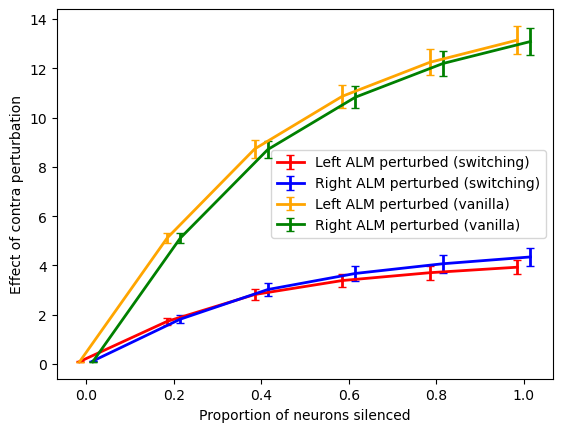

In [40]:
# Collect dip differences across seeds for given probability (0.2)
dip_diffs_left = []
dip_diffs_right = []

dip_diffs_left_vanilla = []
dip_diffs_right_vanilla = []

# Small horizontal offset for better visualization
offset = 0.015

all_probs = np.array(all_probs)  # ensure numpy array for vectorization

# Sherlock switching (51 seeds)
for seed in range(51):
    arr = np.array(all_sherlock_runs[seed][0.2]['all_dip_diff'])
    dip_diffs_left.append(arr[:,0])
    dip_diffs_right.append(arr[:,1])

dip_diffs_left = np.array(dip_diffs_left)      # (51, len(all_probs))
dip_diffs_right = np.array(dip_diffs_right)    # (51, len(all_probs))

mean_left = dip_diffs_left.mean(axis=0)
sem_left = dip_diffs_left.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left.shape[0])
mean_right = dip_diffs_right.mean(axis=0)
sem_right = dip_diffs_right.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right.shape[0])

# Sherlock vanilla (100 seeds)
for seed in range(100):
    arr_vanilla = np.array(all_sherlock_vanilla_runs[seed][0.1]['all_dip_diff'])
    dip_diffs_left_vanilla.append(arr_vanilla[:,0])
    dip_diffs_right_vanilla.append(arr_vanilla[:,1])

dip_diffs_left_vanilla = np.array(dip_diffs_left_vanilla)      # (100, len(all_probs))
dip_diffs_right_vanilla = np.array(dip_diffs_right_vanilla)    # (100, len(all_probs))

mean_left_vanilla = dip_diffs_left_vanilla.mean(axis=0)
sem_left_vanilla = dip_diffs_left_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left_vanilla.shape[0])
mean_right_vanilla = dip_diffs_right_vanilla.mean(axis=0)
sem_right_vanilla = dip_diffs_right_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right_vanilla.shape[0])

# --- Plot mean ± SEM (with lines and error bars), no per-seed scatter ---
plt.errorbar(
    all_probs - offset, mean_left, yerr=sem_left, fmt='-', color='red', capsize=3,
    label='Left ALM perturbed (switching)', linewidth=2, zorder=10
)
plt.errorbar(
    all_probs + offset, mean_right, yerr=sem_right, fmt='-', color='blue', capsize=3,
    label='Right ALM perturbed (switching)', linewidth=2, zorder=10
)
plt.errorbar(
    all_probs - offset, mean_left_vanilla, yerr=sem_left_vanilla, fmt='-', color='orange', capsize=3,
    label='Left ALM perturbed (vanilla)', linewidth=2, zorder=10
)
plt.errorbar(
    all_probs + offset, mean_right_vanilla, yerr=sem_right_vanilla, fmt='-', color='green', capsize=3,
    label='Right ALM perturbed (vanilla)', linewidth=2, zorder=10
)

plt.xlabel('Proportion of neurons silenced')
plt.ylabel('Effect of contra perturbation')
plt.legend()

### Replicating across multiple ratios of holdout inputs

ratios = np.load('sherlock_modularity_multratios_analysis.npy', allo)

In [23]:
sherlock_ratios = np.load('figs/sherlock_modularity_multratios_analysis.npy', allow_pickle=True).item()
ratios[0].keys(), all_sherlock_runs[0][0.2].keys()

(dict_keys([1.0, 0.91, 0.7, 0.55, 0.4]),
 dict_keys(['all_dip_diff', 'all_dip_sem']))

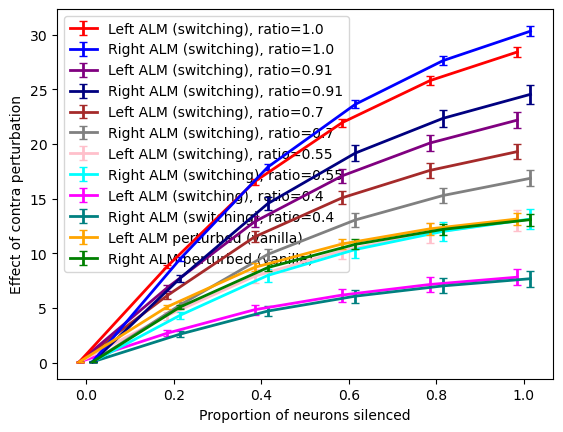

In [25]:
all_ratios = np.array([1.0, 0.91, 0.7, 0.55, 0.4])

# Small horizontal offset for better visualization
offset = 0.015
all_probs = np.array(all_probs)  # ensure numpy array for vectorization

colors_left = ['red', 'purple', 'brown', 'pink', 'magenta']
colors_right = ['blue', 'navy', 'grey', 'cyan', 'teal']

# Vanilla run (kept the same as before)
dip_diffs_left_vanilla = []
dip_diffs_right_vanilla = []

for seed in range(100):
    arr_vanilla = np.array(all_sherlock_vanilla_runs[seed][0.1]['all_dip_diff'])
    dip_diffs_left_vanilla.append(arr_vanilla[:,0])
    dip_diffs_right_vanilla.append(arr_vanilla[:,1])

dip_diffs_left_vanilla = np.array(dip_diffs_left_vanilla)      # (100, len(all_probs))
dip_diffs_right_vanilla = np.array(dip_diffs_right_vanilla)    # (100, len(all_probs))

mean_left_vanilla = dip_diffs_left_vanilla.mean(axis=0)
sem_left_vanilla = dip_diffs_left_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left_vanilla.shape[0])
mean_right_vanilla = dip_diffs_right_vanilla.mean(axis=0)
sem_right_vanilla = dip_diffs_right_vanilla.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right_vanilla.shape[0])

# Plot all switching ratios for left/right hemi, one line per ratio
for i, ratio in enumerate(all_ratios):
    dip_diffs_left = []
    dip_diffs_right = []
    for seed in range(50):
        arr = np.array(sherlock_ratios[seed][ratio]['all_dip_diff'])
        dip_diffs_left.append(arr[:,0])
        dip_diffs_right.append(arr[:,1])
    dip_diffs_left = np.array(dip_diffs_left)
    dip_diffs_right = np.array(dip_diffs_right)
    mean_left = dip_diffs_left.mean(axis=0)
    sem_left = dip_diffs_left.std(axis=0, ddof=1) / np.sqrt(dip_diffs_left.shape[0])
    mean_right = dip_diffs_right.mean(axis=0)
    sem_right = dip_diffs_right.std(axis=0, ddof=1) / np.sqrt(dip_diffs_right.shape[0])
    plt.errorbar(
        all_probs - offset, mean_left, yerr=sem_left, 
        fmt='-', color=colors_left[i % len(colors_left)], capsize=3,
        label=f'Left ALM (switching), ratio={ratio}', linewidth=2, zorder=10-i
    )
    plt.errorbar(
        all_probs + offset, mean_right, yerr=sem_right, 
        fmt='-', color=colors_right[i % len(colors_right)], capsize=3,
        label=f'Right ALM (switching), ratio={ratio}', linewidth=2, zorder=10-i
    )

# Plot vanilla as before
plt.errorbar(
    all_probs - offset, mean_left_vanilla, yerr=sem_left_vanilla, fmt='-', color='orange', capsize=3,
    label='Left ALM perturbed (vanilla)', linewidth=2, zorder=10
)
plt.errorbar(
    all_probs + offset, mean_right_vanilla, yerr=sem_right_vanilla, fmt='-', color='green', capsize=3,
    label='Right ALM perturbed (vanilla)', linewidth=2, zorder=10
)

plt.xlabel('Proportion of neurons silenced')
plt.ylabel('Effect of contra perturbation')
plt.legend()

/var/folders/44/xt3_23490jq3wkm1mj3hq_rw0000gn/T/ipykernel_5185/521830152.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(


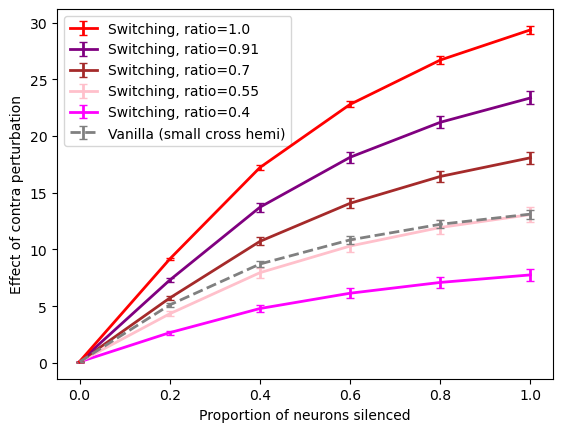

In [31]:
all_ratios = np.array([1.0, 0.91, 0.7, 0.55, 0.4])

# Small horizontal offset for better visualization
offset = 0.015
all_probs = np.array(all_probs)  # ensure numpy array for vectorization

colors_combined = ['red', 'purple', 'brown', 'pink', 'magenta']

# Vanilla run (kept the same as before)
dip_diffs_left_vanilla = []
dip_diffs_right_vanilla = []

for seed in range(100):
    arr_vanilla = np.array(all_sherlock_vanilla_runs[seed][0.1]['all_dip_diff'])
    dip_diffs_left_vanilla.append(arr_vanilla[:,0])
    dip_diffs_right_vanilla.append(arr_vanilla[:,1])

dip_diffs_left_vanilla = np.array(dip_diffs_left_vanilla)      # (100, len(all_probs))
dip_diffs_right_vanilla = np.array(dip_diffs_right_vanilla)    # (100, len(all_probs))

# Combine left and right values for vanilla
combined_vanilla = np.concatenate([dip_diffs_left_vanilla, dip_diffs_right_vanilla], axis=0)  # (200, len(all_probs))
mean_combined_vanilla = combined_vanilla.mean(axis=0)
sem_combined_vanilla = combined_vanilla.std(axis=0, ddof=1) / np.sqrt(combined_vanilla.shape[0])

# Plot all switching ratios, combining left and right hemispheres within each ratio
for i, ratio in enumerate(all_ratios):
    dip_diffs_left = []
    dip_diffs_right = []
    for seed in range(50):
        arr = np.array(sherlock_ratios[seed][ratio]['all_dip_diff'])
        dip_diffs_left.append(arr[:,0])
        dip_diffs_right.append(arr[:,1])
    dip_diffs_left = np.array(dip_diffs_left)
    dip_diffs_right = np.array(dip_diffs_right)
    # Combine left and right for this ratio
    dip_diffs_combined = np.concatenate([dip_diffs_left, dip_diffs_right], axis=0) # (100, len(all_probs))
    mean_combined = dip_diffs_combined.mean(axis=0)
    sem_combined = dip_diffs_combined.std(axis=0, ddof=1) / np.sqrt(dip_diffs_combined.shape[0])
    # Only one line per ratio, combining left/right
    plt.errorbar(
        all_probs, mean_combined, yerr=sem_combined, 
        fmt='-', color=colors_combined[i % len(colors_combined)], capsize=3,
        label=f'Switching, ratio={ratio}', linewidth=2, zorder=10-i
    )

# Plot vanilla as a single combined line
plt.errorbar(
    all_probs, mean_combined_vanilla, yerr=sem_combined_vanilla, fmt='-', color='grey', capsize=3, ls='--',
    label='Vanilla (small cross hemi)', linewidth=2, zorder=10
)

plt.xlabel('Proportion of neurons silenced')
plt.ylabel('Effect of contra perturbation')
plt.legend()